<a href="https://colab.research.google.com/github/zyduan202/BASF_Project2/blob/main/Alternative_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file contains code for training models other than the random forest regressor, using the same dataset and approach detailed in the reference paper.

# A. Data preparation

In [ ]:
!pip install shap
!pip install scikit-optimize

import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import operator
import inspect
from operator import itemgetter
from math import sqrt
from joblib import dump, load
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, LeaveOneOut, cross_validate
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from xgboost import XGBRegressor


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.2 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
data = pd.read_excel('/content/PNNL_data_FinalCurated.xlsx', sheet_name ='Initial set')

In [ ]:
X = data[["crystal radius",'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy",
          "GHSV","H2CO","Temp"]]

X_des = data[["crystal radius",'Pauling Electronegativity','FE','OE',
          'valence s','valence p',"valence d",'valence f','specific heat',
          "thermal conductivity","Cohesive energy"]]

X_con = data[["GHSV","H2CO","Temp"]]

y = data['F_STY']

In [ ]:
np.mean(y)

28.15303215303215

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)
# test_size = 0.15 as used in the provided paper

In [ ]:
def plot_features_vs_target(X, y, title, rows, cols):
    features = X.columns
    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows)) # Adjust the size based on the number of subplots
    axs = axs.ravel() # To handle the subplots easily

    for i, feature in enumerate(features):
        axs[i].scatter(X[feature], y)
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Target (F_STY)')
        axs[i].set_title(f'Target vs. {feature}')

    # Remove empty subplots
    if len(features) < rows*cols:
        for ax in axs[len(features):]:
            fig.delaxes(ax)

    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=20)
    plt.show()

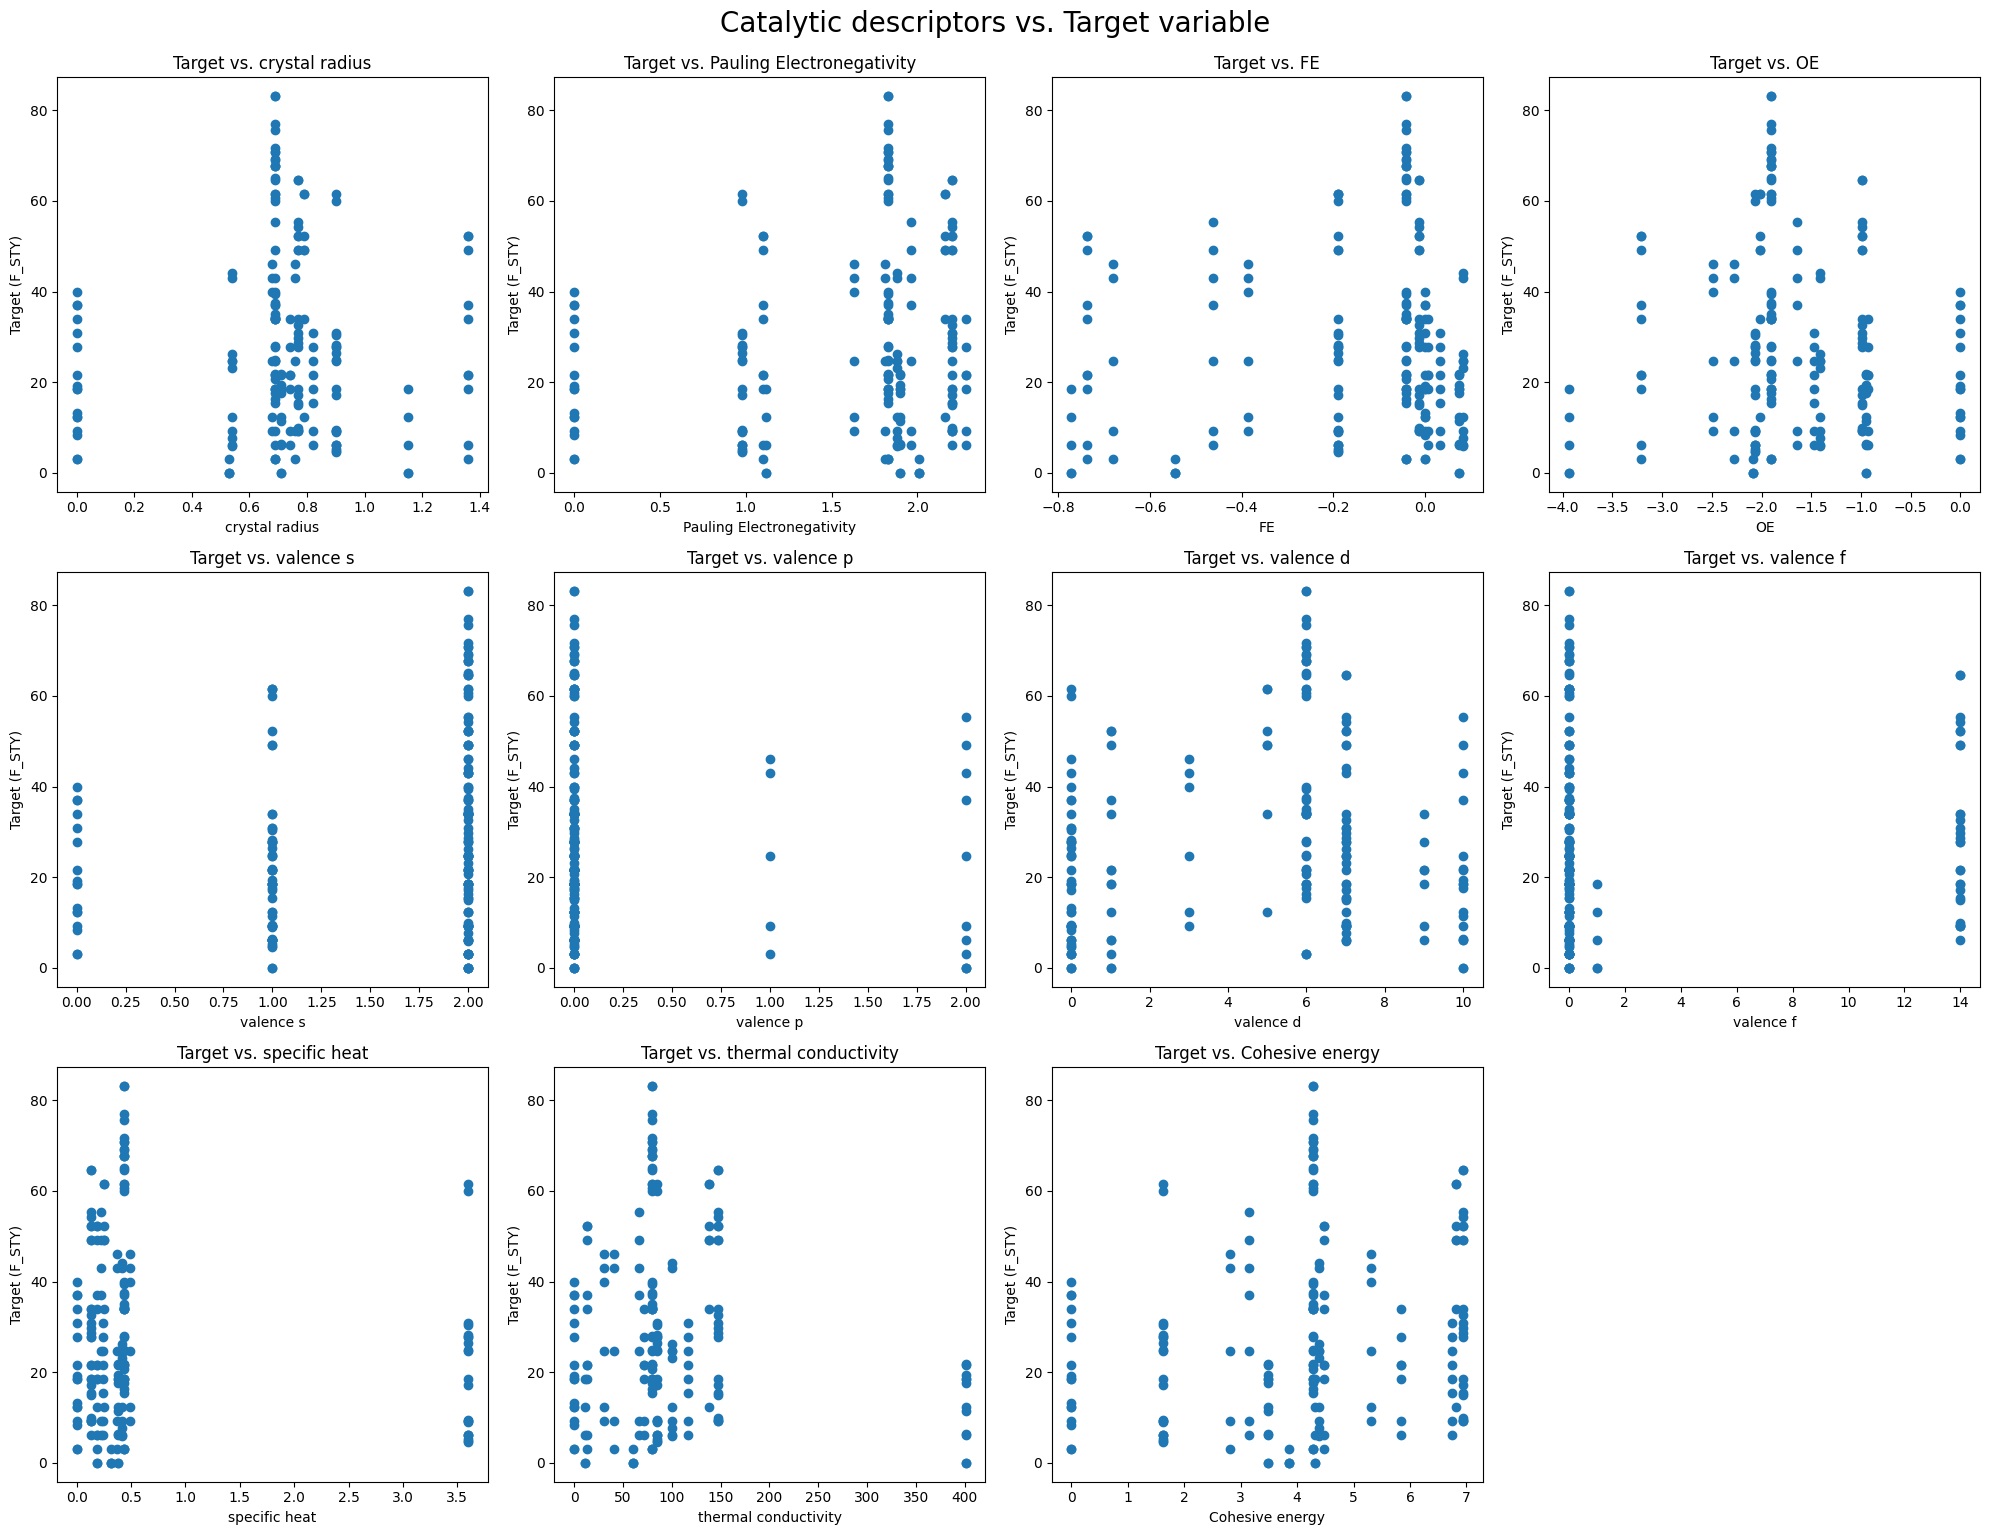

In [ ]:
plot_features_vs_target(X_des, y, 'Catalytic descriptors vs. Target variable', 3, 4)

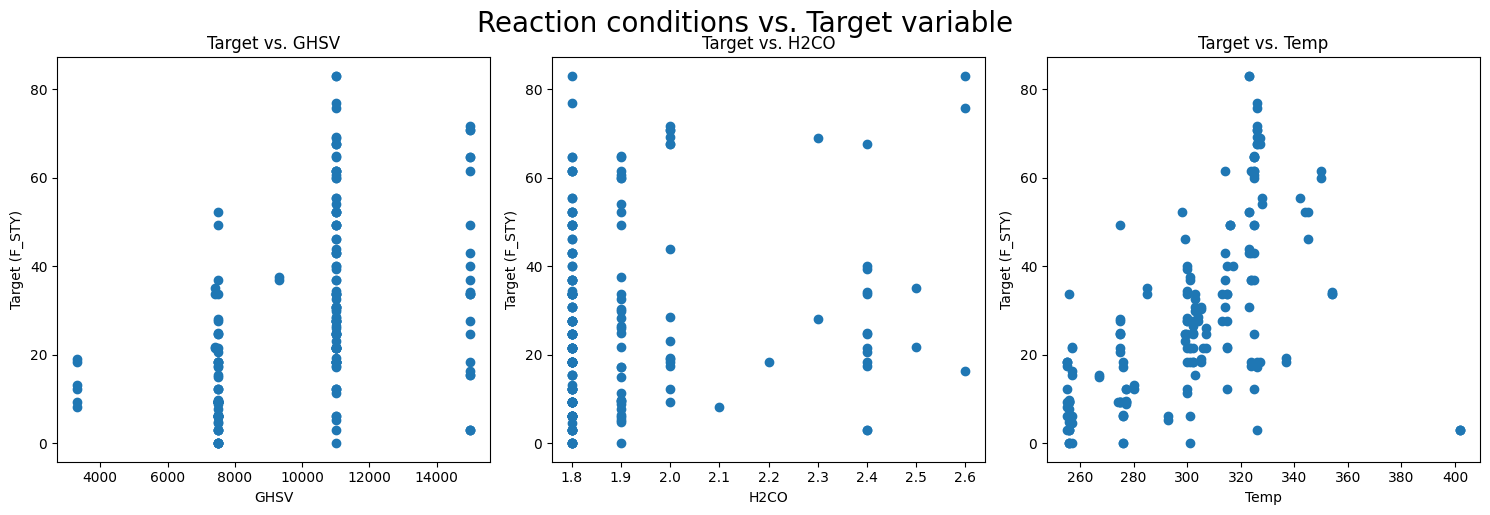

In [ ]:
plot_features_vs_target(X_con, y, 'Reaction conditions vs. Target variable', 1, 3)

highly non-linear relationship between X and y -> linear models are unsuitable

In [ ]:
# plot_features_vs_target(X, y, 'Input Features vs. Target variable', 5,3)

# B. Class and function definition


### ModelEvaluatorBayes()

In [ ]:
class ModelEvaluatorBayes:
    def __init__(self, X, y, random_seeds, model, param_space, kernel=None, results_dict={}, IIS_dict={}, model_dict={}):
        self.X = X
        self.y = y
        self.model = model
        self.param_space = param_space
        self.kernel = kernel
        self.performance_metrics = []
        self.parameters = {}  # Updated to dictionary
        self.seed_shap_dict = {} # Store mean absolute SHAP values across seeds
        self.stored_shap_values = {} # Store SHAP values across seeds for the plot_SHAP method
        self.results_dict = results_dict
        self.IIS_dict = IIS_dict
        self.model_dict = model_dict
        self.temp_shap_rank_dict = {feature: [] for feature in self.X.columns} # Store feature rank based on its SHAP value
        self.non_zero_shap_freq_dict = {feature: 0 for feature in self.X.columns}

        if isinstance(random_seeds, int):
            self.random_seeds = [random_seeds]
        elif isinstance(random_seeds, (list, np.ndarray)):
            self.random_seeds = random_seeds

    def _calculate_shap_values(self, model_fitted, seed):
        """Calculate SHAP values and SHAP value ranking for a given model and seed."""
        try:
            explainer = shap.Explainer(model_fitted, self.X_train)
        except:
            explainer = shap.Explainer(model_fitted.predict, self.X_train)

        shap_values = explainer(self.X_train)
        self.stored_shap_values[seed] = shap_values
        seed_shap_values = {feature_name: np.mean(np.abs(shap_values.values[:, i])) for i, feature_name in enumerate(self.X_train.columns)}
        self.seed_shap_dict[seed] = seed_shap_values

        # Calculate frequency of non-zero SHAP values for each feature.
        for feature_name, value in seed_shap_values.items():
            if value != 0:
                self.non_zero_shap_freq_dict[feature_name] += 1

        # Only rank the features with non-zero SHAP values
        non_zero_shap_features = [k for k, v in seed_shap_values.items() if v != 0]
        seed_shap_ranks = {k: rank+1 for rank, k in enumerate(sorted(non_zero_shap_features, key=seed_shap_values.get, reverse=True))}

        for feature_name, shap_rank in seed_shap_ranks.items():
            self.temp_shap_rank_dict[feature_name].append(shap_rank)


    def _calculate_IIS(self):
        # mean_shap_ranks = {}

        # Compute average rank across seeds only for non-zero ranks
        mean_shap_ranks = {feature: np.mean(ranks) for feature, ranks in self.temp_shap_rank_dict.items() if ranks}

        # Compute frequency of non-zero SHAP values
        total_seeds = len(self.random_seeds)
        non_zero_frequency = {feature: freq / total_seeds for feature, freq in self.non_zero_shap_freq_dict.items()}

        # Combine average rank and frequency
        alpha, beta = 0.33, 0.67  # These weights can be adjusted based on needs

        # self.IIS_data = {}
        IIS_data = {}

        for feature in self.X.columns:
            if feature not in mean_shap_ranks and non_zero_frequency.get(feature, 0) == 0:
                # If SHAP value is zero across all seeds, set IIS to 0
                iis_value = 0
                mean_rank = None
                frequency = 0
            else:
                iis_value = alpha * (1 / mean_shap_ranks.get(feature, float('inf'))) + beta * non_zero_frequency.get(feature, 0) ### 这行仔细看下
                mean_rank = mean_shap_ranks.get(feature, None)
                frequency = non_zero_frequency.get(feature, 0) * 100  # Convert to percentage

            IIS_data[feature] = [mean_rank, frequency, iis_value]

        self.IIS_dict[self.model.__name__] = IIS_data

    def _calculate_evaluation_metrics(self, model_fitted):
        train_r2 = model_fitted.score(self.X_train, self.y_train)
        test_r2 = model_fitted.score(self.X_test, self.y_test)

        y_predicted_train = model_fitted.predict(self.X_train)
        y_predicted_test = model_fitted.predict(self.X_test)

        train_rmse = sqrt(mean_squared_error(self.y_train, y_predicted_train))
        test_rmse = sqrt(mean_squared_error(self.y_test, y_predicted_test))

        accuracies = cross_val_score(estimator=model_fitted, X=self.X_train, y=self.y_train, cv=5)
        cv_r2 = accuracies.mean()

        return {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'cv_r2': cv_r2
        }

    def evaluate_model(self):
        # self.temp_shap_rank_dict = {feature: [] for feature in self.X.columns}
        metrics_accumulator = []

        for seed in self.random_seeds:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=seed)

            if issubclass(self.model, GaussianProcessRegressor) and self.kernel:
                estimator = self.model(kernel=self.kernel, random_state=seed)
            elif 'random_state' in self.model.get_params(self.model()):
                estimator = self.model(random_state=seed)
            else:
                estimator = self.model()

            tuning = BayesSearchCV(estimator=estimator,
                                  search_spaces=self.param_space,
                                  cv=10, #########
                                  n_jobs=-1,
                                  random_state=seed)
            tuning.fit(self.X_train, self.y_train)

            # Special handling for GaussianProcessRegressor
            if issubclass(self.model, GaussianProcessRegressor) and self.kernel:
                model_fitted = GaussianProcessRegressor(kernel=self.kernel,
                                                        alpha=tuning.best_estimator_.alpha,
                                                        n_restarts_optimizer=10,
                                                        random_state=seed)
                model_fitted.fit(self.X_train, self.y_train)
            else:
                model_fitted = tuning.best_estimator_
                model_fitted.fit(self.X_train, self.y_train)

            metrics = self._calculate_evaluation_metrics(model_fitted)
            metrics_accumulator.append(metrics)
            self.performance_metrics.append([seed] + list(metrics.values()))

            self.parameters[seed] = tuning.best_params_

            # Call the SHAP calculation method
            self._calculate_shap_values(model_fitted, seed)

            self.model_dict[self.model.__name__ + "_seed_" + str(seed)] = model_fitted

            print('Random seed ' + str(seed) + ' finished')
            print()

        mean_metrics = {metric: np.mean([result[metric] for result in metrics_accumulator]) for metric in metrics_accumulator[0]}
        self.results_dict[self.model.__name__] = mean_metrics

        self._calculate_IIS()

    def show_performance(self):
        return pd.DataFrame(self.performance_metrics, columns=['random_seed', 'training R2', 'test R2', 'training RMSE', 'test RMSE', 'cv_score'])

    def show_parameters(self):
        return self.parameters

    def show_shap_ranks(self):
        return self.temp_shap_rank_dict

    def show_IIS(self):
        """Return a sorted DataFrame of features with their Integrated Importance Score (IIS), mean rank, and frequency."""

        if not self.IIS_dict or self.model.__name__ not in self.IIS_dict:
            raise ValueError("Please first evaluate the model to compute the IIS values.")

        # Convert nested dictionary to list of lists for DataFrame creation
        data = [[feature] + values for feature, values in self.IIS_dict[self.model.__name__].items()]

        iis_df = pd.DataFrame(data, columns=["Feature", "Mean Rank", "Non-Zero Frequency (%)", "IIS"])

        return iis_df.sort_values(by="IIS", ascending=False)

    def plot_SHAP(self, seed=None):
        if seed == 'all':
            for seed in self.random_seeds:
                self.plot_SHAP(seed)
        else:
            if seed is None:
                seed = self.random_seeds[-1]

            if seed not in self.seed_shap_dict:
                raise ValueError(f"No SHAP values stored for seed {seed}")

            shap_values = self.stored_shap_values[seed]
            shap.plots.bar(shap_values, max_display=15)


## IISDataAnalysis()

In [ ]:
class IISDataAnalysis:

    def __init__(self, results={}, IIS={}, models={}, results_csv_name='df_results.csv',
                 models_joblib_name='models.joblib', iis_full_csv_name='df_IIS_full.csv', iis_csv_name='df_IIS.csv'):

        # Check if provided filenames are strings
        for arg, value in {'results_csv_name': results_csv_name, 'models_joblib_name': models_joblib_name, 'iis_full_csv_name': iis_full_csv_name, 'iis_csv_name': iis_csv_name}.items():
            if not isinstance(value, str):
                raise ValueError(f"The argument {arg} should be a string. Received: {type(value)}")

        self.results = results
        self.IIS = IIS
        self.models = models
        self.results_csv_name = results_csv_name
        self.models_joblib_name = models_joblib_name
        self.iis_full_csv_name = iis_full_csv_name
        self.iis_csv_name = iis_csv_name
        self._process_data()

    def _process_data(self):
        self.df_results = pd.DataFrame(self.results).T
        self.df_results.to_csv(self.results_csv_name)

        dump(self.models, self.models_joblib_name)

        temp_data = {}
        for model, features in self.IIS.items():
            for feature, values in features.items():
                for i, value_name in enumerate(['Mean Rank', 'Non-Zero Frequency(%)', 'IIS']):
                    col_name = (model, value_name)
                    if col_name not in temp_data:
                        temp_data[col_name] = {}
                    temp_data[col_name][feature] = values[i]
        self.df_IIS_full = pd.DataFrame(temp_data).T
        self.df_IIS_full.to_csv(self.iis_full_csv_name)

        # Extracting IIS values into a new DataFrame with models as rows and features as columns
        self.df_IIS = self.df_IIS_full.loc(axis=0)[:, 'IIS']
        self.df_IIS = self.df_IIS.droplevel(1, axis=0) # drop the level of 'IIS'
        self.df_IIS.to_csv(self.iis_csv_name)

    def show_model_performance(self):
        return self.df_results

    def get_IIS_mean_rank(self):
        df_ranked = self.df_IIS.rank(axis=1, ascending=False, method='min').astype(int)
        iis_ranks = df_ranked.T
        mean_ranks = iis_ranks.mean(axis=1).round(3)
        std_ranks = iis_ranks.std(axis=1).round(3)
        results_df = pd.DataFrame({
            'Feature': mean_ranks.index,
            'Mean Rank': mean_ranks.values,
            'Standard Deviation': std_ranks.values
        })
        return results_df

    def plot_IIS_mean_rank(self):
        df_ranked = self.df_IIS.rank(axis=1, ascending=False, method='min').astype(int)
        mean_ranks = df_ranked.mean().sort_values()
        sorted_columns = mean_ranks.index.tolist()
        plt.figure(figsize=(14, 10))
        sns.boxplot(data=df_ranked[sorted_columns], orient="v")
        plt.title('Box Plot of IIS Ranks across Models')
        plt.ylabel('IIS Ranks')
        plt.xlabel('Features')
        plt.gca().invert_yaxis()
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def show_IIS_values(self):
        return self.df_IIS

    def show_IIS_details(self):
        return self.df_IIS_full

    def show_IIS_ranks(self):
        df_ranked = self.df_IIS.rank(axis=1, ascending=False, method='min').astype(int)
        return df_ranked


## define_search_space()

In [ ]:
def define_search_space(X_train):
    param_space_DT = {
        'max_depth': Integer(1, 10),
        'min_samples_split': Real(0.01, 0.1, 'uniform'),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Integer(1, X_train.shape[1])
    }

    param_space_RF = {
        'max_depth': Integer(1, 10),
        'min_samples_split': Real(0.01, 0.1, 'uniform'),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Integer(1, X_train.shape[1])
    }

    param_space_GB = {
        'n_estimators': Integer(10, 200),
        'max_depth': Integer(1, 10),
        'learning_rate': Real(1e-3, 1, 'log-uniform'),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 10),
    }

    param_space_XGB = {
        'n_estimators': Integer(10, 200),
        'max_depth': Integer(1, 10),
        'learning_rate': Real(1e-3, 1, 'log-uniform'),
        'reg_alpha': Real(1e-6, 100.0, 'log-uniform'),
        'reg_lambda': Real(1e-6, 100.0, 'log-uniform'),
    }


    param_space_SVR = {'C': Real(1e-1, 1000, prior='log-uniform'),
                   'gamma': Categorical(['scale', 'auto']),
                   'epsilon': Real(0.1, 0.5, prior='uniform'),
                   'kernel': Categorical(['rbf', 'sigmoid'])
                  }

    param_space_GP = {
        'kernel__k1__k1__constant_value': Real(1e-1, 1e3, 'log-uniform'),
        'kernel__k1__k2__length_scale': Real(1e-6, 1e-1, 'log-uniform'),
        'kernel__k1__k2__alpha': Real(1e-1, 1e6, 'log-uniform'),
        'kernel__k2__noise_level': Real(1e-1, 1e3, 'log-uniform'),
        'alpha': Real(1e-2, 1e4, 'log-uniform'),
    }

    param_space_KNN = {
        'n_neighbors': Integer(3, 21),
        'weights': Categorical(['uniform', 'distance']),
        'p': Integer(1, 2)
    }

    return param_space_DT, param_space_RF, param_space_GB, param_space_XGB, param_space_SVR, param_space_GP, param_space_KNN


# C. Reference paper model

a random forest model trained on full data set

In [ ]:
# optimal parameters found by GridSearchCV
model_full_RF =  RandomForestRegressor(max_depth = 20,
                                       max_features = 'sqrt',
                                       min_samples_split = 2,
                                       n_estimators = 100,
                                       random_state = 0)
model_full_RF.fit(X, y)

# training set R2
model_score = model_full_RF.score(X,y)
print("training set R2: %.3f"% model_full_RF.score(X, y))

# training set MSE and RMSE
y_predicted_all = model_full_RF.predict(X)
print("training set MSE: %.3f"% mean_squared_error(y, y_predicted_all))
print("training set RMSE: %.3f"% sqrt(mean_squared_error(y, y_predicted_all)))


# k-cross validation
scores = cross_validate(estimator = model_full_RF, X=X, y=y, cv=5, scoring=('r2'), return_train_score=True)
accuracies = cross_val_score(estimator = model_full_RF, X = X, y= y, cv=5)

print("training set cv_score: %.3f"% accuracies.mean())


training set R2: 0.976
training set MSE: 9.825
training set RMSE: 3.135
training set cv_score: 0.556


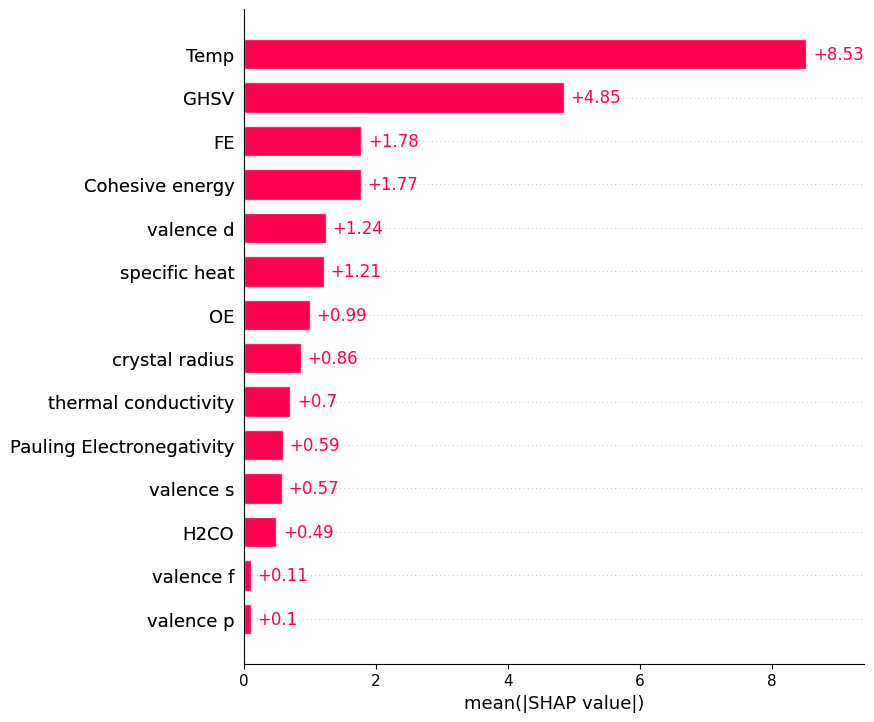

In [ ]:
explainer = shap.Explainer(model_full_RF)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=15)

# D. Alternative models

In [ ]:
# Initialize an empty dictionary to store the evaluation results
results = {}

# Initialize an empty dictionary to store the mean SHAP values
IIS = {}

# Initialize an empty dictionary to store models
models = {}

In [ ]:
# Define search space with X_train
param_space_DT, param_space_RF, param_space_GB, param_space_XGB, param_space_SVR, param_space_GP, param_space_KNN = define_search_space(X_train)

## Decision tree regressor

In [ ]:
random_seeds = np.arange(0,10)

model_DT = ModelEvaluatorBayes(X, y, random_seeds, DecisionTreeRegressor, param_space_DT, results_dict=results, IIS_dict=IIS, model_dict=models)
model_DT.evaluate_model()

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 0 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Random seed 1 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Random seed 2 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Random seed 3 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 4 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Random seed 5 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Random seed 6 finished

Random seed 7 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Random seed 8 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


Random seed 9 finished



In [ ]:
model_DT.show_IIS()

,Feature,Mean Rank,Non-Zero Frequency (%),IIS
13,Temp,1.000000,100.0,1.000000
2,FE,5.100000,100.0,0.734706
6,valence d,5.500000,100.0,0.730000
10,Cohesive energy,6.300000,100.0,0.722381
9,thermal conductivity,8.300000,100.0,0.709759
8,specific heat,4.000000,90.0,0.685500
11,GHSV,5.888889,90.0,0.659038
1,Pauling Electronegativity,6.777778,90.0,0.651689
0,crystal radius,9.555556,90.0,0.637535
3,OE,5.875000,80.0,0.592170


In [ ]:
model_DT.show_shap_ranks()

{'crystal radius': [8, 12, 6, 11, 9, 8, 11, 9, 12],
 'Pauling Electronegativity': [5, 11, 7, 6, 5, 8, 5, 6, 8],
 'FE': [5, 4, 9, 4, 5, 4, 4, 8, 2, 6],
 'OE': [6, 10, 6, 4, 9, 3, 2, 7],
 'valence s': [7, 8, 3, 2, 3, 2],
 'valence p': [12, 12, 12],
 'valence d': [4, 2, 13, 3, 7, 7, 5, 7, 3, 4],
 'valence f': [10, 13],
 'specific heat': [2, 3, 4, 5, 3, 6, 6, 4, 3],
 'thermal conductivity': [7, 9, 5, 9, 10, 13, 9, 4, 8, 9],
 'Cohesive energy': [3, 8, 2, 8, 8, 11, 7, 6, 5, 5],
 'GHSV': [6, 11, 3, 2, 2, 2, 10, 7, 10],
 'H2CO': [9, 10, 7, 10, 11, 10, 12, 11],
 'Temp': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
model_DT.show_performance()

,random_seed,training R2,test R2,training RMSE,test RMSE,cv_score
0,0,0.952659,0.913133,4.513068,5.650254,0.608784
1,1,0.993926,0.785685,1.550791,10.199749,0.620741
2,2,0.997342,0.750198,1.033119,10.669086,0.608113
3,3,0.911774,0.606179,6.055354,12.972017,0.550315
4,4,0.967468,0.644146,3.757446,11.214517,0.644849
5,5,0.996946,0.891163,1.091261,7.590816,0.578484
6,6,0.968729,0.657009,3.729875,10.001408,0.756058
7,7,0.864165,0.735737,7.499414,10.706097,0.409642
8,8,0.748468,0.633500,10.670775,10.091538,0.609538
9,9,0.989981,0.562774,2.112329,11.348858,0.692397


In [ ]:
model_DT.show_parameters()

{0: OrderedDict([('max_depth', 6),
              ('max_features', 14),
              ('min_samples_leaf', 1),
              ('min_samples_split', 0.012056626219000936)]),
 1: OrderedDict([('max_depth', 10),
              ('max_features', 13),
              ('min_samples_leaf', 1),
              ('min_samples_split', 0.013598414354729029)]),
 2: OrderedDict([('max_depth', 10),
              ('max_features', 7),
              ('min_samples_leaf', 1),
              ('min_samples_split', 0.01)]),
 3: OrderedDict([('max_depth', 8),
              ('max_features', 8),
              ('min_samples_leaf', 3),
              ('min_samples_split', 0.01)]),
 4: OrderedDict([('max_depth', 7),
              ('max_features', 10),
              ('min_samples_leaf', 1),
              ('min_samples_split', 0.01)]),
 5: OrderedDict([('max_depth', 9),
              ('max_features', 6),
              ('min_samples_leaf', 1),
              ('min_samples_split', 0.01)]),
 6: OrderedDict([('max_depth', 6),
    

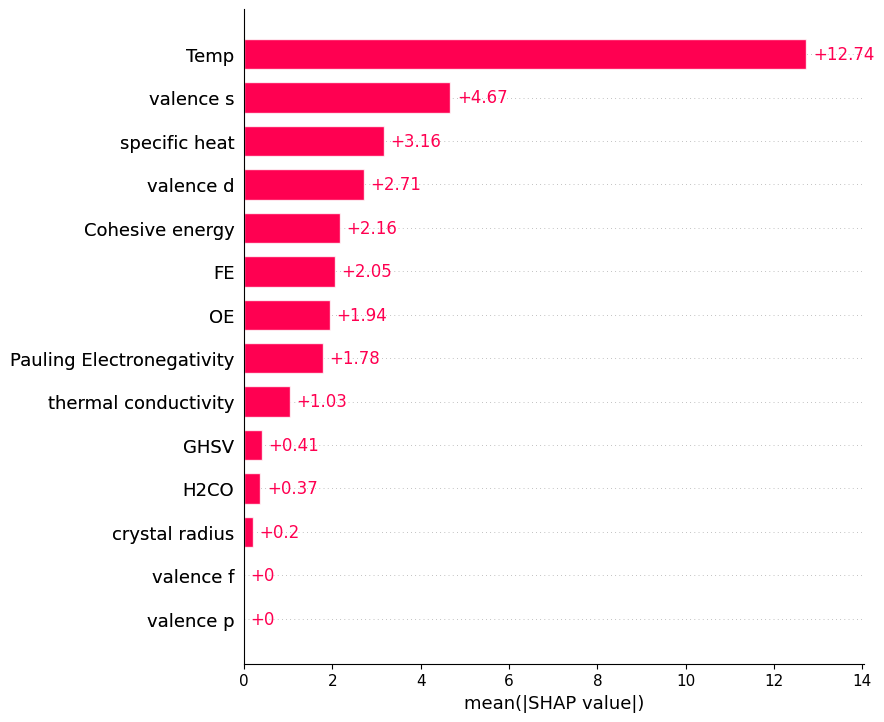

In [ ]:
model_DT.plot_SHAP()

## Gradient Boost regressor

In [ ]:
# 20min
random_seeds = np.arange(0,10)

model_GB = ModelEvaluatorBayes(X, y, random_seeds, GradientBoostingRegressor, param_space_GB, results_dict=results, IIS_dict=IIS, model_dict=models)
model_GB.evaluate_model()

Random seed 0 finished

Random seed 1 finished

Random seed 2 finished

Random seed 3 finished

Random seed 4 finished

Random seed 5 finished

Random seed 6 finished

Random seed 7 finished

Random seed 8 finished

Random seed 9 finished



In [ ]:
model_GB.show_IIS()

,Feature,Mean Rank,Non-Zero Frequency (%),IIS
13,Temp,1.0,100.0,1.000000
10,Cohesive energy,2.9,100.0,0.783793
8,specific heat,3.4,100.0,0.767059
2,FE,4.1,100.0,0.750488
3,OE,6.0,100.0,0.725000
6,valence d,6.1,100.0,0.724098
4,valence s,6.9,100.0,0.717826
0,crystal radius,8.3,100.0,0.709759
9,thermal conductivity,9.1,100.0,0.706264
1,Pauling Electronegativity,9.9,100.0,0.703333


In [ ]:
model_GB.show_shap_ranks()

{'crystal radius': [7, 10, 9, 7, 9, 9, 7, 8, 9, 8],
 'Pauling Electronegativity': [10, 12, 8, 10, 11, 6, 13, 7, 12, 10],
 'FE': [4, 2, 4, 3, 6, 4, 4, 4, 5, 5],
 'OE': [5, 6, 6, 5, 5, 5, 8, 5, 6, 9],
 'valence s': [6, 9, 2, 12, 7, 7, 5, 12, 7, 2],
 'valence p': [13, 14, 12, 14, 14, 13, 11, 14, 13, 14],
 'valence d': [8, 4, 5, 4, 10, 8, 6, 6, 4, 6],
 'valence f': [14, 13, 14, 13, 13, 10, 13, 14, 13],
 'specific heat': [3, 3, 7, 6, 2, 3, 3, 2, 2, 3],
 'thermal conductivity': [9, 7, 11, 9, 4, 12, 14, 10, 8, 7],
 'Cohesive energy': [2, 5, 3, 2, 3, 2, 2, 3, 3, 4],
 'GHSV': [11, 8, 10, 8, 12, 10, 12, 9, 11, 11],
 'H2CO': [12, 11, 13, 11, 8, 11, 9, 11, 10, 12],
 'Temp': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
model_GB.show_performance()

,random_seed,training R2,test R2,training RMSE,test RMSE,cv_score
0,0,0.993787,0.960096,1.634933,3.829581,0.754975
1,1,0.999221,0.798323,0.555325,9.894446,0.764948
2,2,0.993063,0.890445,1.669177,7.065553,0.769931
3,3,0.999185,0.747720,0.582048,10.382443,0.771466
4,4,0.998660,0.623719,0.762523,11.531893,0.822614
5,5,0.985370,0.946886,2.388335,5.302805,0.819815
6,6,0.991457,0.869014,1.949453,6.180619,0.852386
7,7,0.974107,0.932922,3.274266,5.393892,0.630239
8,8,0.997478,0.831486,1.068558,6.842865,0.762775
9,9,0.997230,0.827101,1.110734,7.136680,0.792746


In [ ]:
model_GB.show_parameters()

{0: OrderedDict([('learning_rate', 0.3071142915095849),
              ('max_depth', 3),
              ('min_samples_leaf', 1),
              ('min_samples_split', 2),
              ('n_estimators', 87)]),
 1: OrderedDict([('learning_rate', 0.14388141655682019),
              ('max_depth', 5),
              ('min_samples_leaf', 1),
              ('min_samples_split', 8),
              ('n_estimators', 200)]),
 2: OrderedDict([('learning_rate', 0.06388575665337971),
              ('max_depth', 4),
              ('min_samples_leaf', 1),
              ('min_samples_split', 10),
              ('n_estimators', 200)]),
 3: OrderedDict([('learning_rate', 0.2545253763020059),
              ('max_depth', 10),
              ('min_samples_leaf', 1),
              ('min_samples_split', 10),
              ('n_estimators', 200)]),
 4: OrderedDict([('learning_rate', 0.06359286849808465),
              ('max_depth', 6),
              ('min_samples_leaf', 1),
              ('min_samples_split', 10),
   

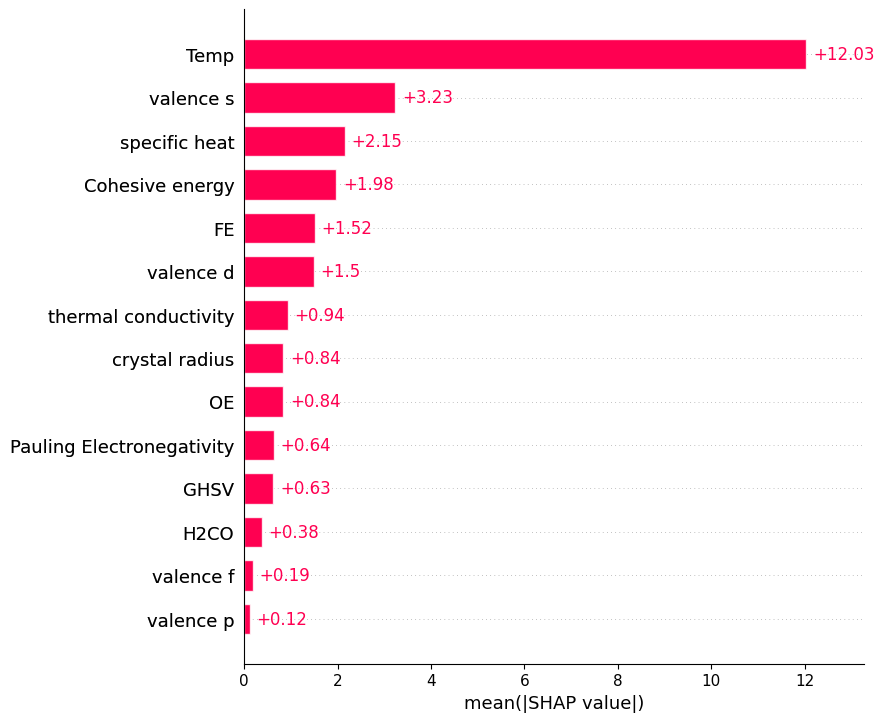

In [ ]:
model_GB.plot_SHAP()

## XGBoost regressor

In [ ]:
random_seeds = np.arange(0,10)
model_XGB = ModelEvaluatorBayes(X, y, random_seeds, XGBRegressor, param_space_XGB, results_dict=results, IIS_dict=IIS, model_dict=models)
model_XGB.evaluate_model()

Random seed 0 finished

Random seed 1 finished

Random seed 2 finished

Random seed 3 finished

Random seed 4 finished

Random seed 5 finished

Random seed 6 finished

Random seed 7 finished

Random seed 8 finished

Random seed 9 finished



In [ ]:
model_XGB.show_IIS()

,Feature,Mean Rank,Non-Zero Frequency (%),IIS
13,Temp,1.000,100.0,1.000000
2,FE,2.800,100.0,0.787857
10,Cohesive energy,4.000,100.0,0.752500
3,OE,5.700,100.0,0.727895
8,specific heat,5.700,100.0,0.727895
0,crystal radius,6.200,100.0,0.723226
6,valence d,6.500,100.0,0.720769
9,thermal conductivity,8.500,100.0,0.708824
4,valence s,8.700,100.0,0.707931
1,Pauling Electronegativity,9.000,100.0,0.706667


In [ ]:
model_XGB.show_shap_ranks()

{'crystal radius': [9, 5, 6, 3, 5, 9, 2, 9, 6, 8],
 'Pauling Electronegativity': [8, 9, 12, 10, 7, 8, 7, 6, 12, 11],
 'FE': [4, 2, 2, 2, 3, 4, 3, 2, 4, 2],
 'OE': [5, 4, 4, 8, 9, 6, 6, 3, 9, 3],
 'valence s': [6, 12, 3, 11, 10, 7, 8, 10, 10, 10],
 'valence p': [11, 13, 13, 13, 13, 12, 13, 13, 13, 13],
 'valence d': [7, 3, 5, 5, 11, 5, 10, 5, 8, 6],
 'valence f': [14, 14, 14, 13, 14, 14, 14, 14],
 'specific heat': [3, 6, 11, 6, 2, 3, 9, 7, 3, 7],
 'thermal conductivity': [13, 8, 8, 7, 8, 14, 5, 8, 5, 9],
 'Cohesive energy': [2, 7, 7, 4, 4, 2, 4, 4, 2, 4],
 'GHSV': [12, 10, 9, 9, 12, 10, 11, 12, 7, 5],
 'H2CO': [10, 11, 10, 12, 6, 11, 12, 11, 11, 12],
 'Temp': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
model_XGB.show_performance()

,random_seed,training R2,test R2,training RMSE,test RMSE,cv_score
0,0,0.952583,0.914604,4.516671,5.602226,0.805690
1,1,0.998854,0.769229,0.673524,10.584101,0.772792
2,2,0.997263,0.847232,1.048491,8.343448,0.776287
3,3,0.970110,0.763582,3.524574,10.050748,0.817866
4,4,0.997800,0.622377,0.977059,11.552442,0.769428
5,5,0.991729,0.955288,1.795726,4.865358,0.819667
6,6,0.995196,0.881791,1.461875,5.871449,0.879319
7,7,0.983499,0.952950,2.613795,4.517466,0.725935
8,8,0.963286,0.724511,4.076748,8.749280,0.775114
9,9,0.997072,0.918412,1.141931,4.902429,0.813872


In [ ]:
model_XGB.show_parameters()

{0: OrderedDict([('learning_rate', 0.04716494815176423),
              ('max_depth', 3),
              ('n_estimators', 161),
              ('reg_alpha', 1e-06),
              ('reg_lambda', 1e-06)]),
 1: OrderedDict([('learning_rate', 0.5122372495795063),
              ('max_depth', 5),
              ('n_estimators', 17),
              ('reg_alpha', 0.00019027270174618382),
              ('reg_lambda', 0.0009702358331516928)]),
 2: OrderedDict([('learning_rate', 0.3952895540607157),
              ('max_depth', 4),
              ('n_estimators', 159),
              ('reg_alpha', 0.02773374860318014),
              ('reg_lambda', 4.751931004379521)]),
 3: OrderedDict([('learning_rate', 0.24483094673974157),
              ('max_depth', 9),
              ('n_estimators', 118),
              ('reg_alpha', 1e-06),
              ('reg_lambda', 100.0)]),
 4: OrderedDict([('learning_rate', 0.03863902636594714),
              ('max_depth', 5),
              ('n_estimators', 200),
              

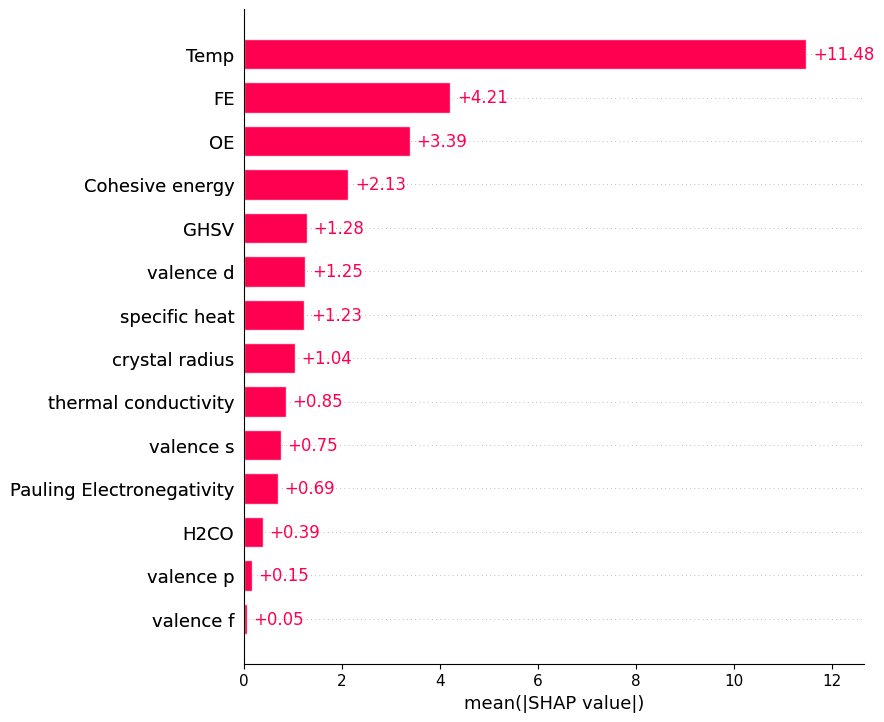

In [ ]:
model_XGB.plot_SHAP()

## Support vector regression

In [ ]:
random_seeds = np.arange(0,10)

model_SVR = ModelEvaluatorBayes(X, y, random_seeds, SVR, param_space_SVR, results_dict=results, IIS_dict=IIS, model_dict=models)
model_SVR.evaluate_model()

The objective has been evaluated at this point before.
Permutation explainer: 152it [01:17,  1.70it/s]


Random seed 0 finished



Permutation explainer: 152it [01:08,  1.91it/s]


Random seed 1 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 2 finished



Permutation explainer: 152it [00:57,  2.19it/s]


Random seed 3 finished



Permutation explainer: 152it [01:03,  2.05it/s]


Random seed 4 finished



Permutation explainer: 152it [01:17,  1.70it/s]


Random seed 5 finished



The objective has been evaluated at this point before.
Permutation explainer: 152it [01:17,  1.71it/s]


Random seed 6 finished



Permutation explainer: 152it [00:58,  2.21it/s]


Random seed 7 finished



Permutation explainer: 152it [01:04,  2.00it/s]


Random seed 8 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
Permutation explainer: 152it [01:04,  1.99it/s]

Random seed 9 finished



In [ ]:
model_SVR.show_IIS()

,Feature,Mean Rank,Non-Zero Frequency (%),IIS
13,Temp,1.0,100.0,1.000000
9,thermal conductivity,2.0,100.0,0.835000
11,GHSV,3.0,100.0,0.780000
6,valence d,4.0,100.0,0.752500
10,Cohesive energy,5.0,100.0,0.736000
7,valence f,6.0,100.0,0.725000
8,specific heat,7.0,100.0,0.717143
3,OE,8.0,100.0,0.711250
4,valence s,9.0,100.0,0.706667
1,Pauling Electronegativity,10.3,100.0,0.702039


In [ ]:
model_SVR.show_shap_ranks()

{'crystal radius': [13, 13, 14, 14, 14, 13, 14, 14, 13, 13],
 'Pauling Electronegativity': [11, 10, 11, 10, 10, 11, 10, 10, 10, 10],
 'FE': [14, 14, 13, 13, 13, 14, 13, 13, 14, 14],
 'OE': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
 'valence s': [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 'valence p': [10, 11, 10, 11, 11, 12, 11, 11, 11, 11],
 'valence d': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 'valence f': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 'specific heat': [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
 'thermal conductivity': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
 'Cohesive energy': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 'GHSV': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 'H2CO': [12, 12, 12, 12, 12, 10, 12, 12, 12, 12],
 'Temp': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
model_SVR.show_performance()

,random_seed,training R2,test R2,training RMSE,test RMSE,cv_score
0,0,0.992595,0.682408,1.784850,10.803778,0.650063
1,1,0.996459,0.706352,1.184039,11.939238,0.496532
2,2,0.993059,0.493712,1.669595,15.188960,0.603789
3,3,0.997191,0.732504,1.080565,10.690956,0.561362
4,4,0.984733,0.313402,2.574013,15.577427,0.666258
5,5,0.996618,0.771384,1.148307,11.001548,0.537091
6,6,0.992793,0.554679,1.790639,11.396096,0.650564
7,7,0.983901,0.734786,2.581748,10.725344,0.576036
8,8,0.992638,0.543612,1.825592,11.261275,0.645526
9,9,0.993005,0.732901,1.765004,8.870238,0.631897


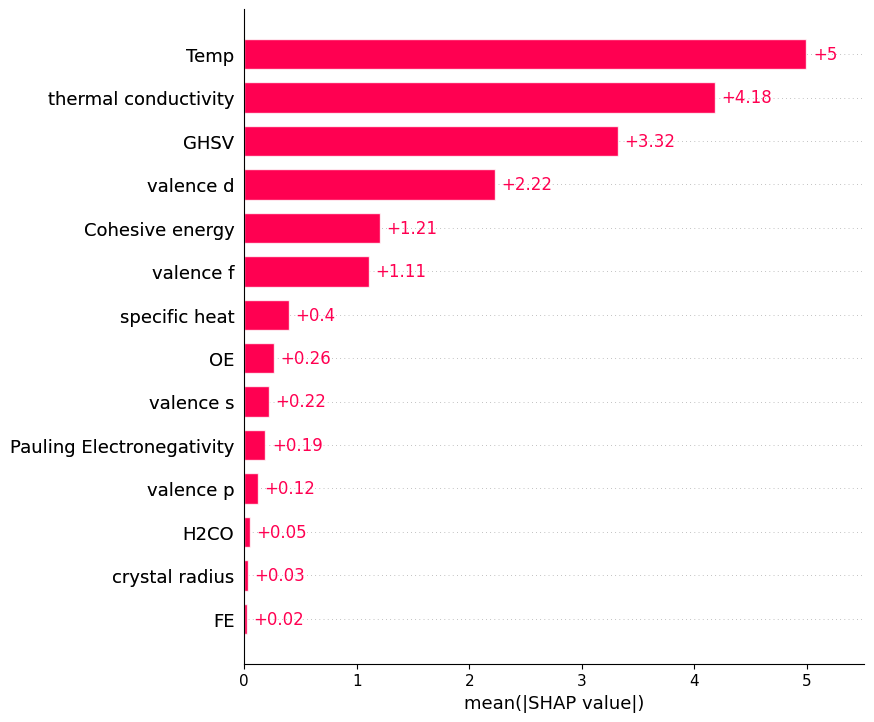

In [ ]:
model_SVR.plot_SHAP()

## KNN for regression

In [ ]:
random_seeds = np.arange(0,10)

model_KNN = ModelEvaluatorBayes(X, y, random_seeds, KNeighborsRegressor, param_space_KNN, results_dict=results, IIS_dict=IIS, model_dict=models)
model_KNN.evaluate_model()

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
Permutation explainer: 152it [00:29,  3.41it/s]


Random seed 0 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
Permutation explainer: 152it [00:34,  3.13it/s]


Random seed 1 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 2 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 3 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 4 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 5 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
Permutation explainer: 152it [00:28,  3.35it/s]


Random seed 6 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 7 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object

Random seed 8 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
Permutation explainer: 152it [00:27,  3.55it/s]

Random seed 9 finished



In [ ]:
model_KNN.show_IIS()

,Feature,Mean Rank,Non-Zero Frequency (%),IIS
11,GHSV,1.1,100.0,0.970000
13,Temp,1.9,100.0,0.843684
9,thermal conductivity,3.0,100.0,0.780000
6,valence d,4.0,100.0,0.752500
10,Cohesive energy,5.3,100.0,0.732264
7,valence f,5.7,100.0,0.727895
8,specific heat,7.1,100.0,0.716479
3,OE,7.9,100.0,0.711772
4,valence s,9.6,100.0,0.704375
1,Pauling Electronegativity,9.8,100.0,0.703673


In [ ]:
model_KNN.show_shap_ranks()

{'crystal radius': [13, 12, 13, 13, 14, 13, 14, 13, 13, 14],
 'Pauling Electronegativity': [10, 10, 10, 9, 10, 11, 10, 9, 9, 10],
 'FE': [12, 11, 12, 14, 13, 14, 11, 12, 12, 13],
 'OE': [8, 8, 8, 8, 8, 8, 8, 7, 8, 8],
 'valence s': [9, 9, 9, 10, 9, 12, 9, 10, 10, 9],
 'valence p': [11, 14, 11, 12, 11, 10, 13, 11, 11, 11],
 'valence d': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 'valence f': [6, 6, 6, 5, 5, 5, 6, 6, 6, 6],
 'specific heat': [7, 7, 7, 7, 7, 7, 7, 8, 7, 7],
 'thermal conductivity': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 'Cohesive energy': [5, 5, 5, 6, 6, 6, 5, 5, 5, 5],
 'GHSV': [1, 1, 1, 2, 1, 1, 1, 1, 1, 1],
 'H2CO': [14, 13, 14, 11, 12, 9, 12, 14, 14, 12],
 'Temp': [2, 2, 2, 1, 2, 2, 2, 2, 2, 2]}

In [ ]:
model_KNN.show_performance()

,random_seed,training R2,test R2,training RMSE,test RMSE,cv_score
0,0,0.997467,0.912021,1.043836,5.686318,0.696327
1,1,0.999350,0.662223,0.507426,12.804962,0.585369
2,2,0.997444,0.811235,1.013100,9.274495,0.714685
3,3,0.999185,0.585957,0.582048,13.300890,0.731176
4,4,0.999297,0.753312,0.552246,9.337240,0.749945
5,5,0.999189,0.930931,0.562201,6.047043,0.653350
6,6,0.997511,0.439939,1.052336,12.780183,0.765662
7,7,0.999455,0.851071,0.475094,8.037160,0.660560
8,8,0.997687,0.411793,1.023184,12.784550,0.753071
9,9,0.997592,0.870944,1.035645,6.165791,0.719228


In [ ]:
model_KNN.show_parameters()

{0: OrderedDict([('n_neighbors', 17), ('p', 1), ('weights', 'distance')]),
 1: OrderedDict([('n_neighbors', 20), ('p', 1), ('weights', 'distance')]),
 2: OrderedDict([('n_neighbors', 19), ('p', 1), ('weights', 'distance')]),
 3: OrderedDict([('n_neighbors', 6), ('p', 2), ('weights', 'distance')]),
 4: OrderedDict([('n_neighbors', 12), ('p', 1), ('weights', 'distance')]),
 5: OrderedDict([('n_neighbors', 3), ('p', 1), ('weights', 'distance')]),
 6: OrderedDict([('n_neighbors', 15), ('p', 1), ('weights', 'distance')]),
 7: OrderedDict([('n_neighbors', 21), ('p', 1), ('weights', 'distance')]),
 8: OrderedDict([('n_neighbors', 12), ('p', 1), ('weights', 'distance')]),
 9: OrderedDict([('n_neighbors', 11), ('p', 1), ('weights', 'distance')])}

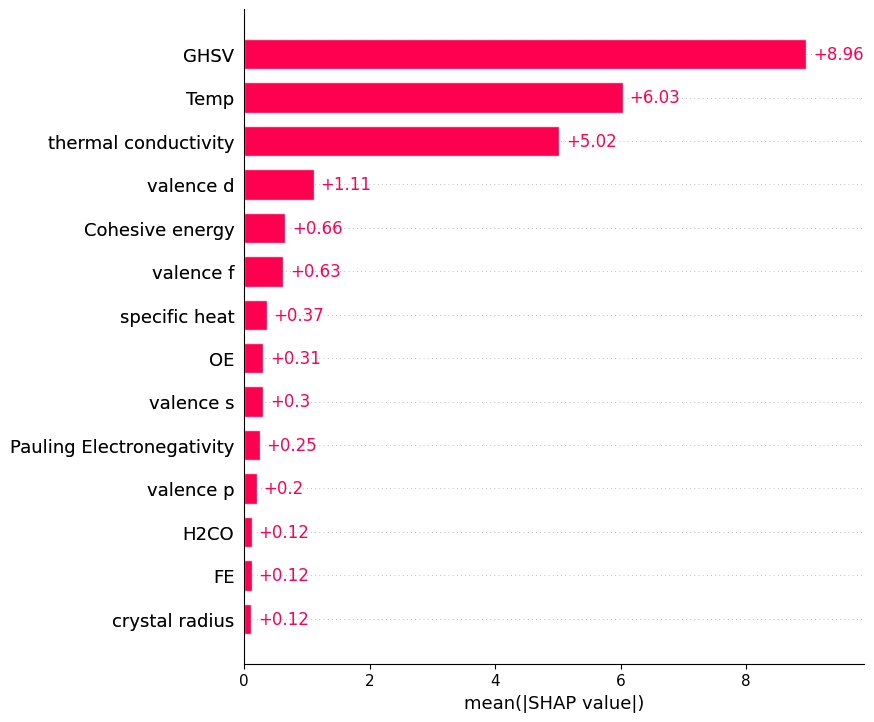

In [ ]:
model_KNN.plot_SHAP()

## Gaussian Process

In [ ]:
random_seeds = np.arange(0,10)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

model_GP = ModelEvaluatorBayes(X, y, random_seeds, GaussianProcessRegressor, param_space_GP, kernel, results_dict=results, IIS_dict=IIS, model_dict=models)
model_GP.evaluate_model()

The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
Permutation explainer: 152it [01:26,  1.52it/s]


Random seed 0 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of pa

Random seed 1 finished



The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
Permutation explainer: 152it [01:27,  1.54it/s]


Random seed 2 finished



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value

Random seed 3 finished



The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
Permutation explainer: 152it [01:27,  1.55it/s]


Random seed 4 finished



The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
Permutation explainer: 152it [01:22,  1.60it/s]


Random seed 5 finished



Permutation explainer: 152it [01:26,  1.53it/s]


Random seed 6 finished



The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
Permutation explainer: 152it [01:28,  1.53it/s]


Random seed 7 finished



lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Permutation explainer: 152it [01:24,  1.58it/s]


Random seed 8 finished



The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
Permutation explainer: 152it [01:26,  1.55it/s]

Random seed 9 finished



In [ ]:
model_GP.show_IIS()

,Feature,Mean Rank,Non-Zero Frequency (%),IIS
11,GHSV,1.2,100.0,0.945000
13,Temp,1.8,100.0,0.853333
9,thermal conductivity,3.0,100.0,0.780000
6,valence d,4.0,100.0,0.752500
7,valence f,5.0,100.0,0.736000
10,Cohesive energy,6.0,100.0,0.725000
8,specific heat,7.1,100.0,0.716479
3,OE,7.9,100.0,0.711772
4,valence s,9.0,100.0,0.706667
1,Pauling Electronegativity,10.1,100.0,0.702673


In [ ]:
model_GP.show_shap_ranks()

{'crystal radius': [13, 12, 14, 13, 13, 13, 14, 14, 14, 13],
 'Pauling Electronegativity': [10, 10, 11, 10, 10, 10, 10, 10, 10, 10],
 'FE': [14, 14, 12, 14, 14, 14, 13, 13, 13, 14],
 'OE': [8, 7, 8, 8, 8, 8, 8, 8, 8, 8],
 'valence s': [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
 'valence p': [11, 13, 10, 12, 11, 11, 11, 11, 11, 11],
 'valence d': [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
 'valence f': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
 'specific heat': [7, 8, 7, 7, 7, 7, 7, 7, 7, 7],
 'thermal conductivity': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
 'Cohesive energy': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 'GHSV': [2, 1, 1, 1, 1, 2, 1, 1, 1, 1],
 'H2CO': [12, 11, 13, 11, 12, 12, 12, 12, 12, 12],
 'Temp': [1, 2, 2, 2, 2, 1, 2, 2, 2, 2]}

In [ ]:
model_GP.show_performance()

,random_seed,training R2,test R2,training RMSE,test RMSE,cv_score
0,0,0.996042,0.896287,1.304872,6.173877,0.751109
1,1,0.999088,0.745624,0.600985,11.112233,0.612817
2,2,0.975092,0.785382,3.162900,9.889217,0.665323
3,3,0.998370,0.739123,0.823067,10.557869,0.759249
4,4,0.996260,0.689373,1.273961,10.477651,0.763362
5,5,0.995552,0.905599,1.316864,7.069492,0.643301
6,6,0.995952,0.689130,1.341961,9.521585,0.797065
7,7,0.996189,0.906711,1.256131,6.361044,0.690188
8,8,0.995165,0.687720,1.479433,9.315209,0.766238
9,9,0.995956,0.864096,1.341896,6.327256,0.765877


In [ ]:
model_GP.show_parameters()

{0: OrderedDict([('alpha', 0.011711910630675615),
              ('kernel__k1__k1__constant_value', 337.65271792609246),
              ('kernel__k1__k2__alpha', 0.1),
              ('kernel__k1__k2__length_scale', 0.07887315954658668),
              ('kernel__k2__noise_level', 38.00705415691963)]),
 1: OrderedDict([('alpha', 0.01),
              ('kernel__k1__k1__constant_value', 1000.0),
              ('kernel__k1__k2__alpha', 0.1),
              ('kernel__k1__k2__length_scale', 0.1),
              ('kernel__k2__noise_level', 1000.0)]),
 2: OrderedDict([('alpha', 58.935145444764245),
              ('kernel__k1__k1__constant_value', 0.1),
              ('kernel__k1__k2__alpha', 0.3044083149050834),
              ('kernel__k1__k2__length_scale', 0.1),
              ('kernel__k2__noise_level', 0.1)]),
 3: OrderedDict([('alpha', 2.652599252226777),
              ('kernel__k1__k1__constant_value', 0.2680186859626047),
              ('kernel__k1__k2__alpha', 0.5834082564629207),
            

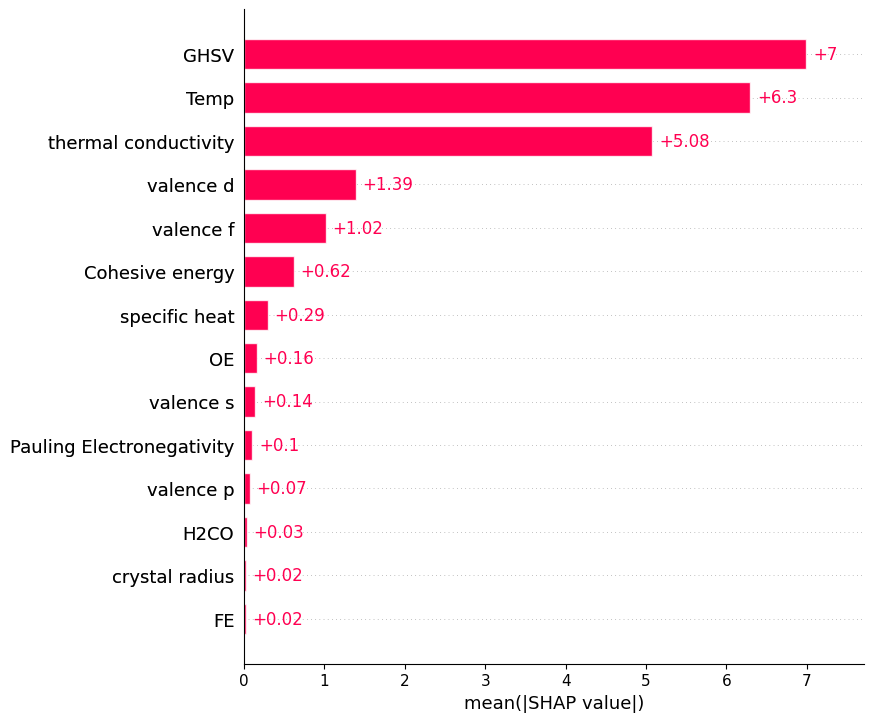

In [ ]:
model_GP.plot_SHAP()

# E. IIS ranking

In [ ]:
IIS_data = IISDataAnalysis(results=results,
                           IIS=IIS,
                           models=models,
                           results_csv_name='df_results.csv',
                           models_joblib_name='models.joblib',
                           iis_full_csv_name='df_IIS_full.csv',
                           iis_csv_name='df_IIS.csv')

results_dict=results, IIS_dict=IIS, model_dict=models

In [ ]:
IIS_data.show_model_performance()

,train_r2,test_r2,train_rmse,test_rmse,cv_r2
DecisionTreeRegressor,0.939146,0.717952,4.201343,10.044434,0.607892
SVR,0.992299,0.626574,1.740435,11.745486,0.601912
KNeighborsRegressor,0.998418,0.722943,0.784712,9.621863,0.702937
GaussianProcessRegressor,0.994367,0.790904,1.390207,8.680543,0.721453
GradientBoostingRegressor,0.992956,0.842771,1.499535,7.356078,0.774189
XGBRegressor,0.984739,0.834997,2.183040,7.503895,0.795597


In [ ]:
IIS_data.show_IIS_values()

,crystal radius,Pauling Electronegativity,FE,OE,valence s,valence p,valence d,valence f,specific heat,thermal conductivity,Cohesive energy,GHSV,H2CO,Temp
DecisionTreeRegressor,0.637535,0.651689,0.734706,0.592170,0.481200,0.228500,0.730000,0.162696,0.685500,0.709759,0.722381,0.659038,0.569000,1.000000
SVR,0.694444,0.702039,0.694444,0.711250,0.706667,0.700275,0.752500,0.725000,0.717143,0.835000,0.736000,0.780000,0.697966,1.000000
KNeighborsRegressor,0.695000,0.703673,0.696613,0.711772,0.704375,0.698696,0.752500,0.727895,0.716479,0.780000,0.732264,0.970000,0.696400,0.843684
GaussianProcessRegressor,0.694812,0.702673,0.694444,0.711772,0.706667,0.699464,0.752500,0.736000,0.716479,0.780000,0.725000,0.945000,0.697731,0.853333
GradientBoostingRegressor,0.709759,0.703333,0.750488,0.725000,0.717826,0.695000,0.724098,0.628385,0.767059,0.706264,0.783793,0.702353,0.700556,1.000000
XGBRegressor,0.723226,0.706667,0.787857,0.727895,0.707931,0.695984,0.720769,0.559784,0.727895,0.708824,0.752500,0.704021,0.701132,1.000000


In [ ]:
IIS_data.show_IIS_details()

crystal radius  \
DecisionTreeRegressor     Mean Rank                    9.555556   
                          Non-Zero Frequency(%)       90.000000   
                          IIS                          0.637535   
SVR                       Mean Rank                   13.500000   
                          Non-Zero Frequency(%)      100.000000   
                          IIS                          0.694444   
KNeighborsRegressor       Mean Rank                   13.200000   
                          Non-Zero Frequency(%)      100.000000   
                          IIS                          0.695000   
GaussianProcessRegressor  Mean Rank                   13.300000   
                          Non-Zero Frequency(%)      100.000000   
                          IIS                          0.694812   
GradientBoostingRegressor Mean Rank                    8.300000   
                          Non-Zero Frequency(%)      100.000000   
                          IIS                          0.709759   
XGBRegressor              Mean Rank                    6.200000   
                          Non-Zero Frequency(%)      100.000000   
                          IIS                          0.723226   

                                                 Pauling Electronegativity  \
DecisionTreeRegressor     Mean Rank                               6.777778   
                          Non-Zero Frequency(%)                  90.000000   
                          IIS                                     0.651689   
SVR                       Mean Rank                              10.300000   
                          Non-Zero Frequency(%)                 100.000000   
                          IIS                                     0.702039   
KNeighborsRegressor       Mean Rank                               9.800000   
                          Non-Zero Frequency(%)                 100.000000   
                          IIS                                     0.703673   
GaussianProcessRegressor  Mean Rank                              10.100000   
                          Non-Zero Frequency(%)                 100.000000   
                          IIS                                     0.702673   
GradientBoostingRegressor Mean Rank                               9.900000   
                          Non-Zero Frequency(%)                 100.000000   
                          IIS                                     0.703333   
XGBRegressor              Mean Rank                               9.000000   
                          Non-Zero Frequency(%)                 100.000000   
                          IIS                                     0.706667   

                                                         FE          OE  \
DecisionTreeRegressor     Mean Rank                5.100000    5.875000   
                          Non-Zero Frequency(%)  100.000000   80.000000   
                          IIS                      0.734706    0.592170   
SVR                       Mean Rank               13.500000    8.000000   
                          Non-Zero Frequency(%)  100.000000  100.000000   
                          IIS                      0.694444    0.711250   
KNeighborsRegressor       Mean Rank               12.400000    7.900000   
                          Non-Zero Frequency(%)  100.000000  100.000000   
                          IIS                      0.696613    0.711772   
GaussianProcessRegressor  Mean Rank               13.500000    7.900000   
                          Non-Zero Frequency(%)  100.000000  100.000000   
                          IIS                      0.694444    0.711772   
GradientBoostingRegressor Mean Rank                4.100000    6.000000   
                          Non-Zero Frequency(%)  100.000000  100.000000   
                          IIS                      0.750488    0.725000   
XGBRegressor              Mean Rank                2.800000    5.700000   
                 

In [ ]:
IIS_data.show_IIS_ranks()

,crystal radius,Pauling Electronegativity,FE,OE,valence s,valence p,valence d,valence f,specific heat,thermal conductivity,Cohesive energy,GHSV,H2CO,Temp
DecisionTreeRegressor,9,8,2,10,12,13,3,14,6,5,4,7,11,1
SVR,13,10,13,8,9,11,4,6,7,2,5,3,12,1
KNeighborsRegressor,14,10,12,8,9,11,4,6,7,3,5,1,13,2
GaussianProcessRegressor,13,10,14,8,9,11,4,5,7,3,6,1,12,2
GradientBoostingRegressor,8,10,4,5,7,13,6,14,3,9,2,11,12,1
XGBRegressor,6,10,2,4,9,13,7,14,4,8,3,11,12,1


In [ ]:
IIS_data.get_IIS_mean_rank()

,Feature,Mean Rank,Standard Deviation
0,Temp,1.333,0.516
1,Cohesive energy,4.167,1.472
2,valence d,4.667,1.506
3,thermal conductivity,5.000,2.898
4,specific heat,5.667,1.751
5,GHSV,5.667,4.676
6,OE,7.167,2.229
7,FE,7.833,5.742
8,valence s,9.167,1.602
9,Pauling Electronegativity,9.667,0.816


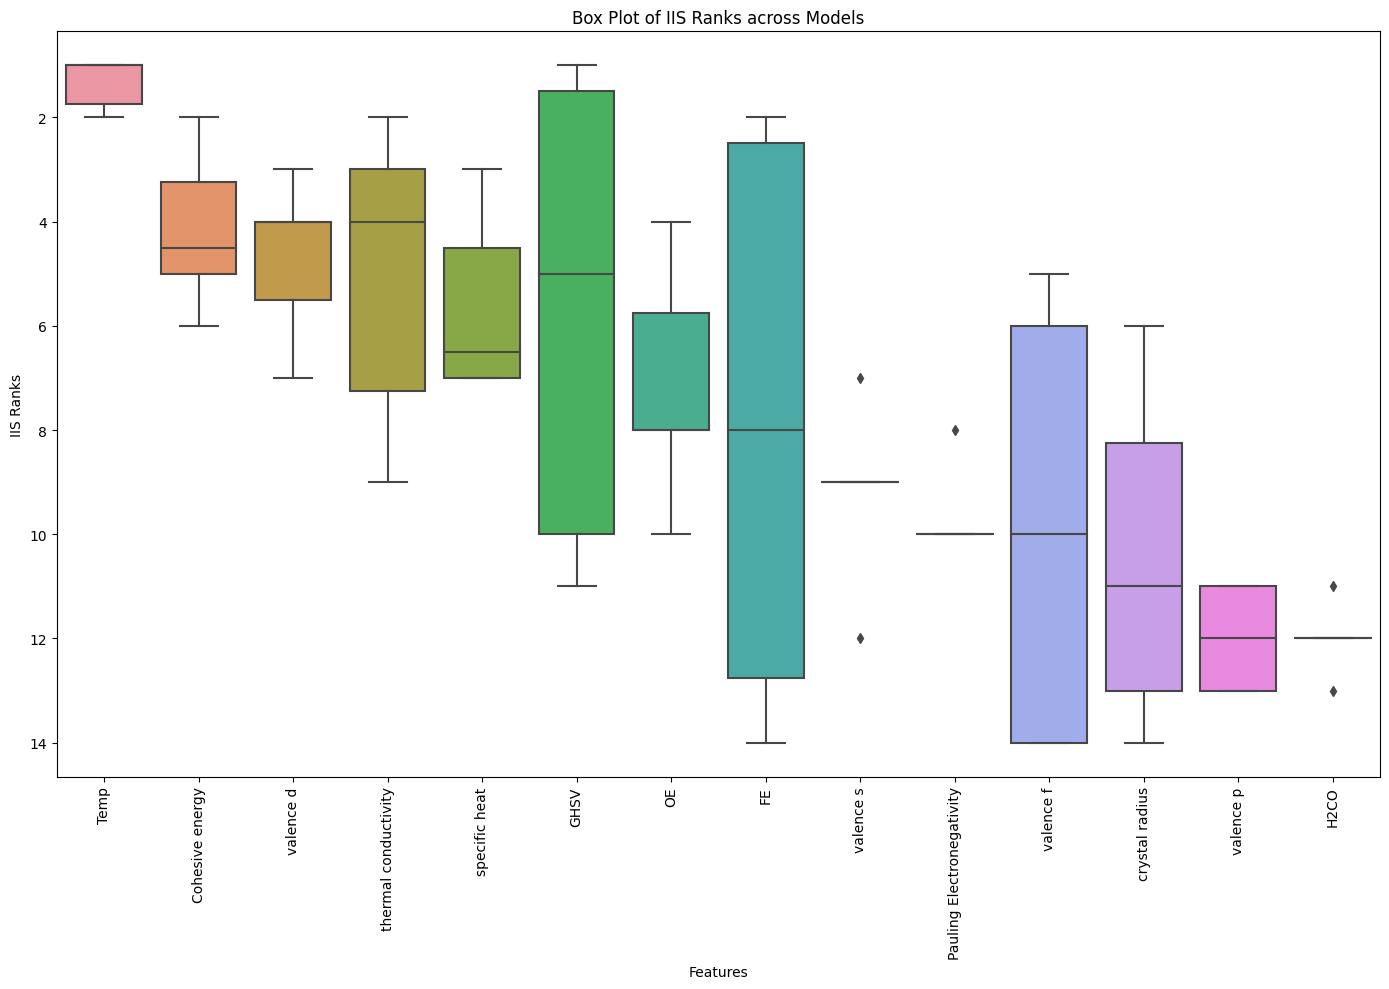

In [ ]:
IIS_data.plot_IIS_mean_rank()